In [39]:
import os
import pandas as pd
from pathlib import Path
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import json

In [40]:
cpath = Path(os.getcwd())
annotation = pd.read_csv(cpath.parent / "paper" / 'tables' / 'selected_targets_benchmark.csv', index_col='Name')
seq2int = dict(annotation['sequence_int'])
seq2pdb = dict(annotation['PDB name'])

annotation

,Number of samples in the train set,Dataset type,Family name,UniProt ID,PDB name,L1 family name,L2 family name,sequence_int
Name,,,,,,,,
ESR1,4483,easy,Nuclear receptor,P03372,2r6w,Transcription factor,Nuclear receptor,138
HCRTR1,12691,easy,GPCR,O43613,4zjc,Membrane receptor,Family A G protein-coupled receptor,176
JAK1,12455,easy,Kinase,P23458,3eyg,Enzyme,Kinase,1145
P2RX3,5140,easy,Ion channel,P56373,5svl,Ion channel,Ligand-gated ion channel,2054
KDM1A,4622,easy,Protein-protein interaction target,O60341,5lhg,Epigenetic regulator,Eraser,2281
IDH1,5177,easy,Non-kinase enzyme,O75874,4umx,Enzyme,Oxidoreductase,2908
RIOK1,15,hard,Kinase,Q9BRS2,4otp,Enzyme,Kinase,1163
NR4A1,28,hard,Nuclear receptor,P22736,3v3q,Transcription factor,Nuclear receptor,1230
GRIK1,335,hard,Ion channel,P39086,3fv1,Ion channel,Ligand-gated ion channel,1852


In [41]:
json_path = cpath.parent / 'data' / 'experiments' / 'diffusion' / 'categorical_mappings.json'

with json_path.open() as f:
    cate_mappings = json.load(f)

inv_dict = {v: k for k, v in cate_mappings['sequence'].items()}

In [42]:
from Bio.PDB import PDBParser, PPBuilder

def read_fasta_pdb(pdb_path):
    """ Simple fasta reader """
    # Load the PDB file

    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_path)
    
    # Use Polypeptide builder to get peptide chains
    ppb = PPBuilder()

    fasta = {}
    # Extract sequences from all chains and output FASTA
    for model in structure:
        for chain in model:
            sequence = ''
            for pp in ppb.build_peptides(chain):
                sequence += pp.get_sequence()
            if sequence:
                fasta[chain.id] = sequence
                # print(f">Chain {chain.id}\n{sequence}")
    return fasta

In [43]:
# save PDB fasta to filtered_sequence.txt 
import json
fasta_pdb = {}
for gene, seq_i in seq2int.items():
    fasta_seq = read_fasta_pdb(cpath.parent / 'data' / 'CrossDocked2020' / f'{seq2pdb[gene]}' / f'{seq2pdb[gene]}_protein_cleaned.pdb')
    fasta_seq = next(iter(fasta_seq.values()))
    fasta_pdb[gene] = str(fasta_seq)

esm_path = cpath.parent / 'data' / 'esm'
os.makedirs(esm_path, exist_ok=True)
with open(esm_path / 'mapping.json', 'wt') as f:
    json.dump(fasta_pdb, f, indent=2)

with open(esm_path / 'filtered_sequence.txt', 'wt') as f:
    f.writelines([x+'\n' for x in fasta_pdb.values()])

In [44]:
from Bio import Align

aligner = Align.PairwiseAligner()
aligner.mode = 'global'
aligner.substitution_matrix = Align.substitution_matrices.load("BLOSUM62")

# Set gap penalties to match BLASTP defaults
aligner.open_gap_score = -11  # Gap open penalty
aligner.extend_gap_score = -1  # Gap extend penalty

stats = {}
for gene, seq_i in seq2int.items():
    fasta_seq = fasta_pdb[gene]
    alignments = aligner.align(str(inv_dict[seq_i]), str(fasta_seq))
    alignments = sorted(alignments)
    if len(alignments) >= 2:
        print(alignments[0].score, alignments[1].score)

    alignment = alignments[0]
    stats[gene] = alignment.counts()._asdict()
    stats[gene]['len_fasta'] = len(fasta_seq)
    stats[gene]['len_seq'] = len(inv_dict[seq_i])
  
    # print(alignment.score)
    # print(alignment)

stats = pd.DataFrame(stats).T
stats.index.name = 'gene'
stats = stats.reset_index()

1361.0 1361.0
667.0 667.0
941.0 941.0


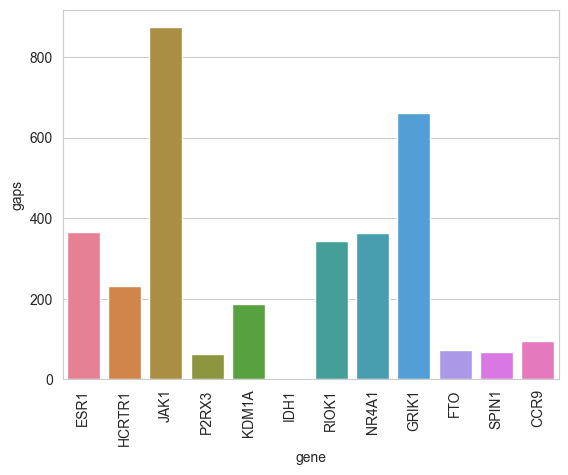

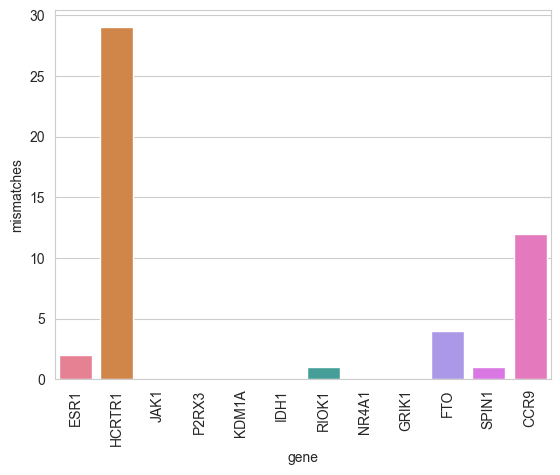

In [45]:
seaborn.barplot(stats, y='gaps', x='gene', hue='gene')
plt.tick_params(axis='x', rotation=90)
plt.show()

seaborn.barplot(stats, y='mismatches', x='gene', hue='gene')
plt.tick_params(axis='x', rotation=90)
plt.show()